In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import random
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime   ### 시간 계산
from detectron2 import model_zoo
from detectron2.engine.defaults import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import detectron2.data.transforms as T
import torch
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

from pathlib import Path
import pickle 

In [2]:
trainDataJSONDir = "train/trainSet.json"
trainImagesDir = "train/JPEGImages"
register_coco_instances("licensePlate_train", {}, trainDataJSONDir, trainImagesDir)
licensPlate_train_metadata = MetadataCatalog.get("licensePlate_train")
train_dataset_dicts = DatasetCatalog.get("licensePlate_train")

WARNING [04/29 13:53:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 13:53:04 d2.data.datasets.coco]: Loaded 331 images in COCO format from train/trainSet.json


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("licensePlate_train",)    
cfg.MODEL.DEVICE='cpu' #만약 gpu를 사용한다면 ‘cuda’로 수정
cfg.DATASETS.TEST = ()    
cfg.DATALOADER.NUM_WORKERS = 2
# model zoo를 사용하여 훈련 초기화
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
# Learning rate 설정
cfg.SOLVER.BASE_LR = 0.00025 
# iteration 수 설정 
cfg.SOLVER.MAX_ITER = 100 
# 실습 데이타셋 학습을 위한 이미지 크기 조절 (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 111   
# 1개 class만 감지
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

trainer.resume_or_load(resume=False)
trainer.train()

[04/29 13:47:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [02:30, 1.18MB/s]                                                                        
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask

[04/29 13:49:34 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\user\anaconda3\envs\detectron\lib\site-packages\detectron2\structures\image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
C:\Users\user\anaconda3\envs\detectron\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
from detectron2.engine import DefaultPredictor
weightDir = "output/platemodel.pth" # 모델 가중치 파일 경로
cfg.MODEL.WEIGHTS = weightDir
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # 해당 수치가 낮으면 검출이 더 잘되지만 잘못된 예측이 증가. 높으면 엄격한 검출이 됨.
testPredictor = DefaultPredictor(cfg)
fileName = "testimg/5.jpg" #예측하고자 하는 영상파일의 경로
inputImage = cv2.imread(fileName)
testOutputs = testPredictor(inputImage)
v = Visualizer(inputImage[:, :, ::-1],
               None,
               scale=1.0, 
               instance_mode=ColorMode.IMAGE_BW  #예측되지 않는 영역을 회색으로 바꿈
)
v = v.draw_instance_predictions(testOutputs["instances"].to("cpu"))
plt.imshow(v.get_image())
plt.axis('off')

NameError: name 'cfg' is not defined

C:\Users\user\anaconda3\envs\detectron\lib\site-packages\detectron2\structures\image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
C:\Users\user\anaconda3\envs\detectron\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 499.5, 499.5, -0.5)

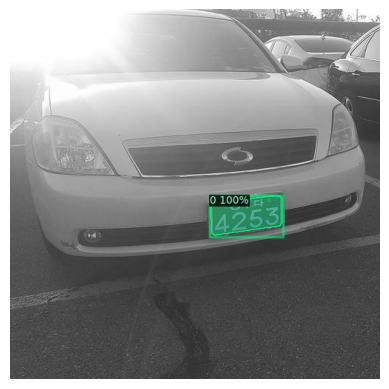

In [4]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt
import cv2
from detectron2.utils.visualizer import Visualizer, ColorMode

myConfig = get_cfg()
myConfig.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
weightDir = "platemodel.pth" # 모델 가중치 파일 경로
myConfig.MODEL.WEIGHTS = weightDir
myConfig.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # 해당 수치가 낮으면 검출이 더 잘되지만 잘못된 예측이 증가. 높으면 엄격한 검출이 됨.
myConfig.MODEL.ROI_HEADS.NUM_CLASSES = 1  
myConfig.MODEL.DEVICE='cpu'
real_testPredictor = DefaultPredictor(myConfig)

fileName = "testimg/5.jpg" #예측하고자 하는 영상파일의 경로
inputImage = cv2.imread(fileName)
real_testOutputs = real_testPredictor(inputImage)
v = Visualizer(inputImage[:, :, ::-1],
               None,
               scale=1.0, 
               instance_mode=ColorMode.IMAGE_BW  #예측되지 않는 영역을 회색으로 바꿈
)
v = v.draw_instance_predictions(real_testOutputs["instances"].to("cpu"))
plt.imshow(v.get_image())
plt.axis('off')